# AER615 Project 2
This project involves writing a program that analyzes the climb performance of a Piper Cherokee. The program works by inputting the various altitudes desired, and depending on the function parameters prints various plots or data at those altitudes. The data that is returned when the `mode` argument is set to `'data'` is in a Pandas DataFrame.

Program usage is demonstrated below:

In [1]:
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import numpy as np
import pandas as pd

from climb_analysis import climb_analysis

In [2]:
altitudes = [5000, 10000, 15000] # in feet
ca = climb_analysis(altitudes, plot_style=['science', 'no-latex'], fig_size=[230, (7,4)])

## Part 1 - Plotting Maximum Attainable Rate of Climb

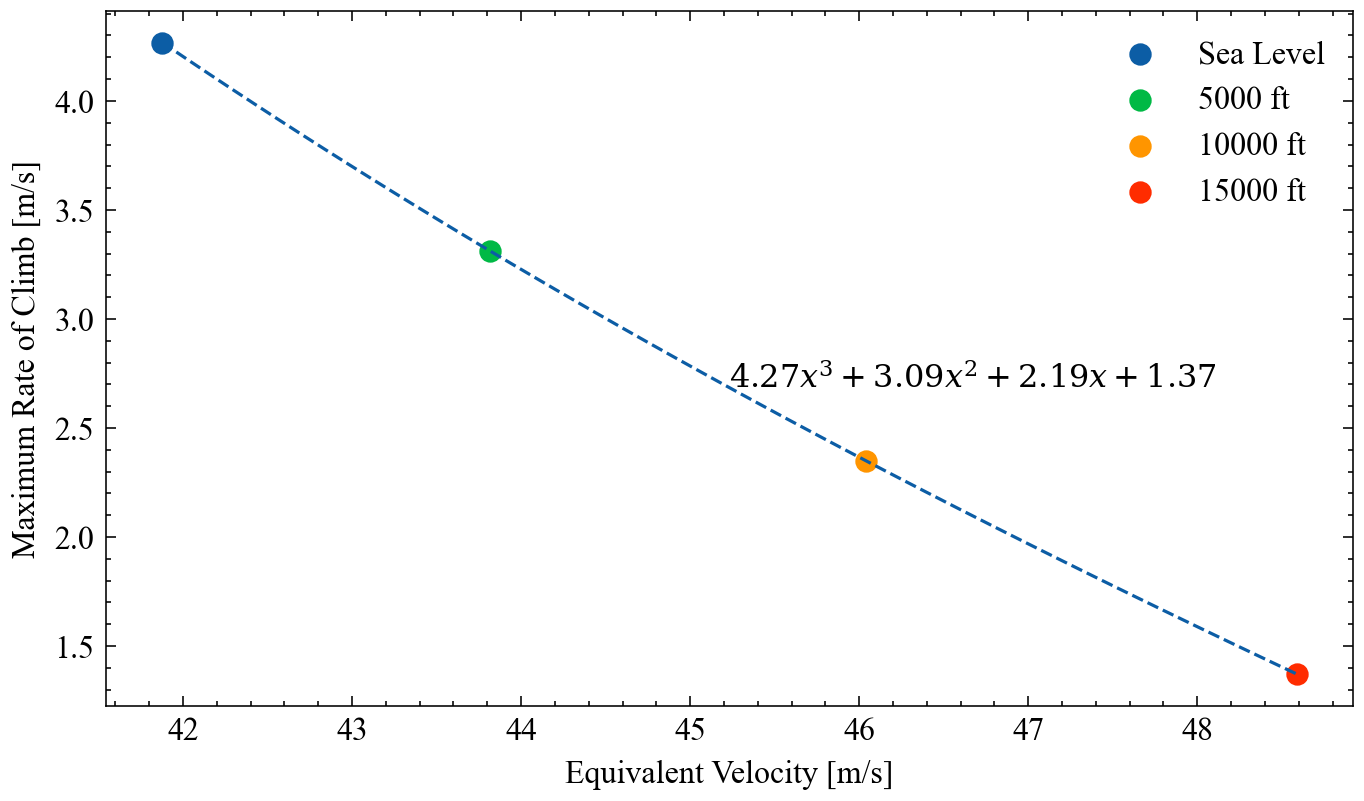

In [3]:
ca.max_roc(metric=True, mode='plot')

In [4]:
max_roc_metric = ca.max_roc(metric=True, mode='data')
max_roc_metric

,Altitude [m],Equivalent Velocity [m/s],Maximum Rate of Climb [m/s]
0,0.0,41.877423,4.267824
1,1524.0,43.814421,3.312736
2,3048.0,46.039145,2.350058
3,4572.0,48.587593,1.372063


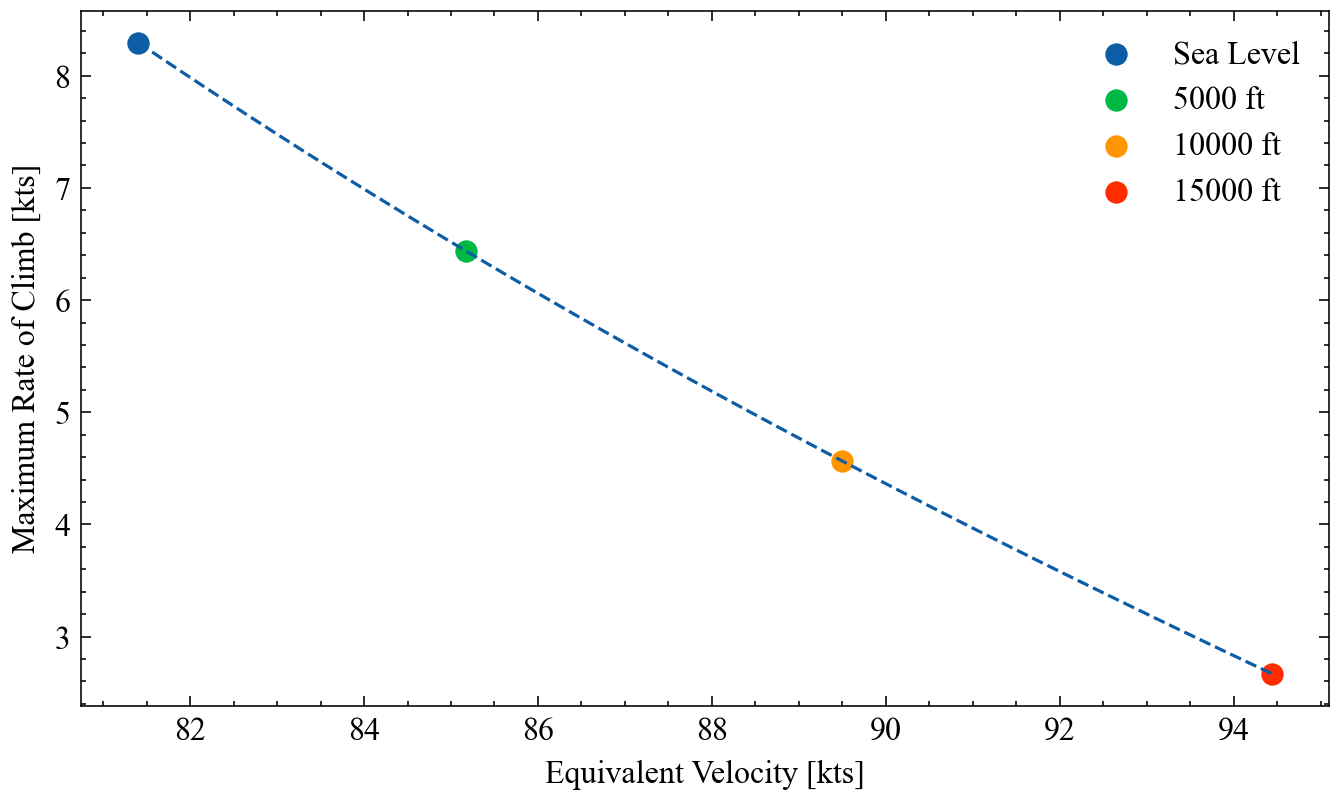

Spline coefficients:  [8.29596668 6.00783075 4.25542106 2.66707149]


In [5]:
ca.max_roc(metric=False, mode='plot')

In [6]:
max_roc_imperial = ca.max_roc(metric=False, mode='data')
max_roc_imperial

,Altitude [ft],Equivalent Velocity [kts],Maximum Rate of Climb [kts]
0,0.0,81.403010,8.295967
1,5000.0,85.168225,6.439428
2,10000.0,89.492731,4.568136
3,15000.0,94.446506,2.667071


## Part 2 - Plotting Hodographs

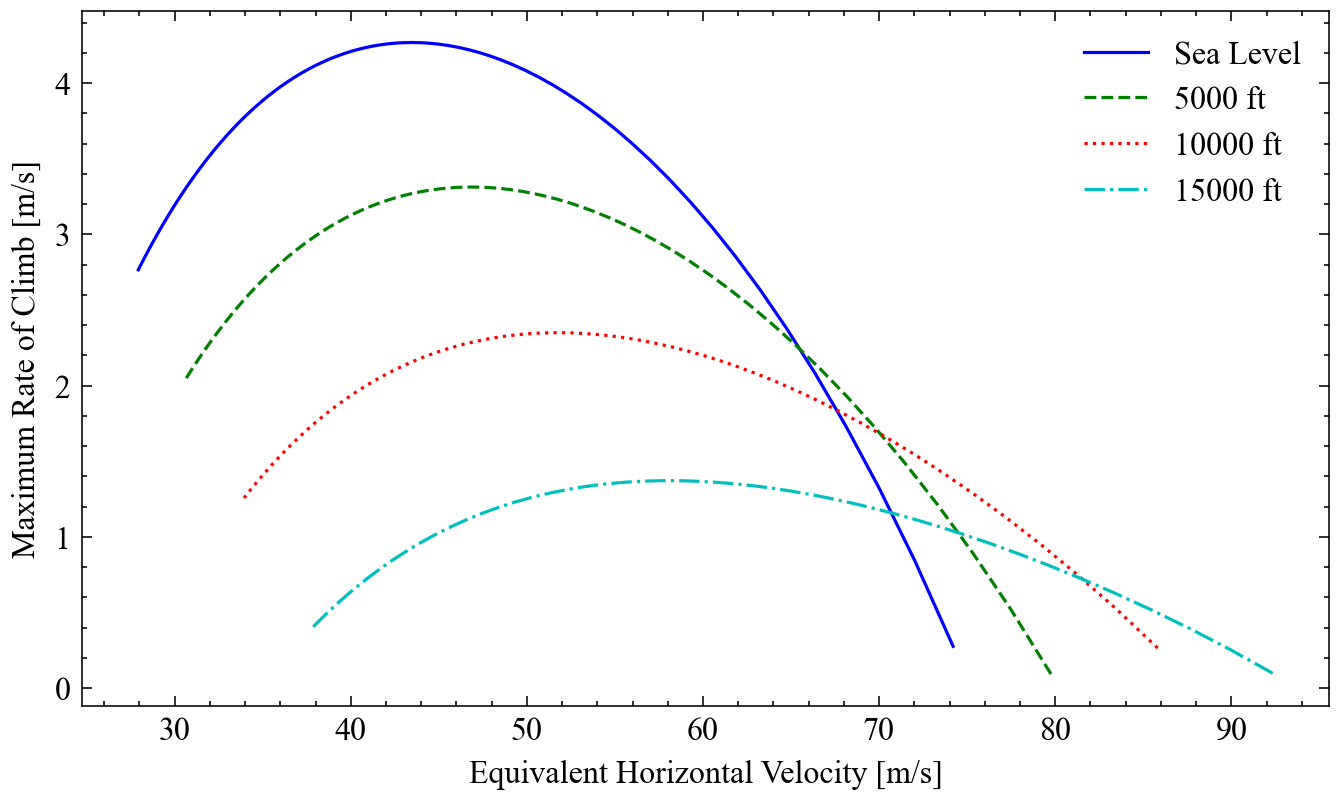

In [7]:
ca.hodograph(metric=True, mode='plot')

In [8]:
hodo_metric = ca.hodograph(metric=True, mode='data')

hodo_metric.head()

,True Velocity [kts],0.0 [m],1524.0 [m],3048.0 [m],4572.0 [m]
0,27.588137,2.765763,2.036874,1.250091,0.406065
1,27.709043,2.794436,2.063297,1.274691,0.429311
2,27.831552,2.823126,2.089711,1.299262,0.452511
3,27.955701,2.851830,2.116113,1.323799,0.475662
4,28.081526,2.880544,2.142499,1.348299,0.498759


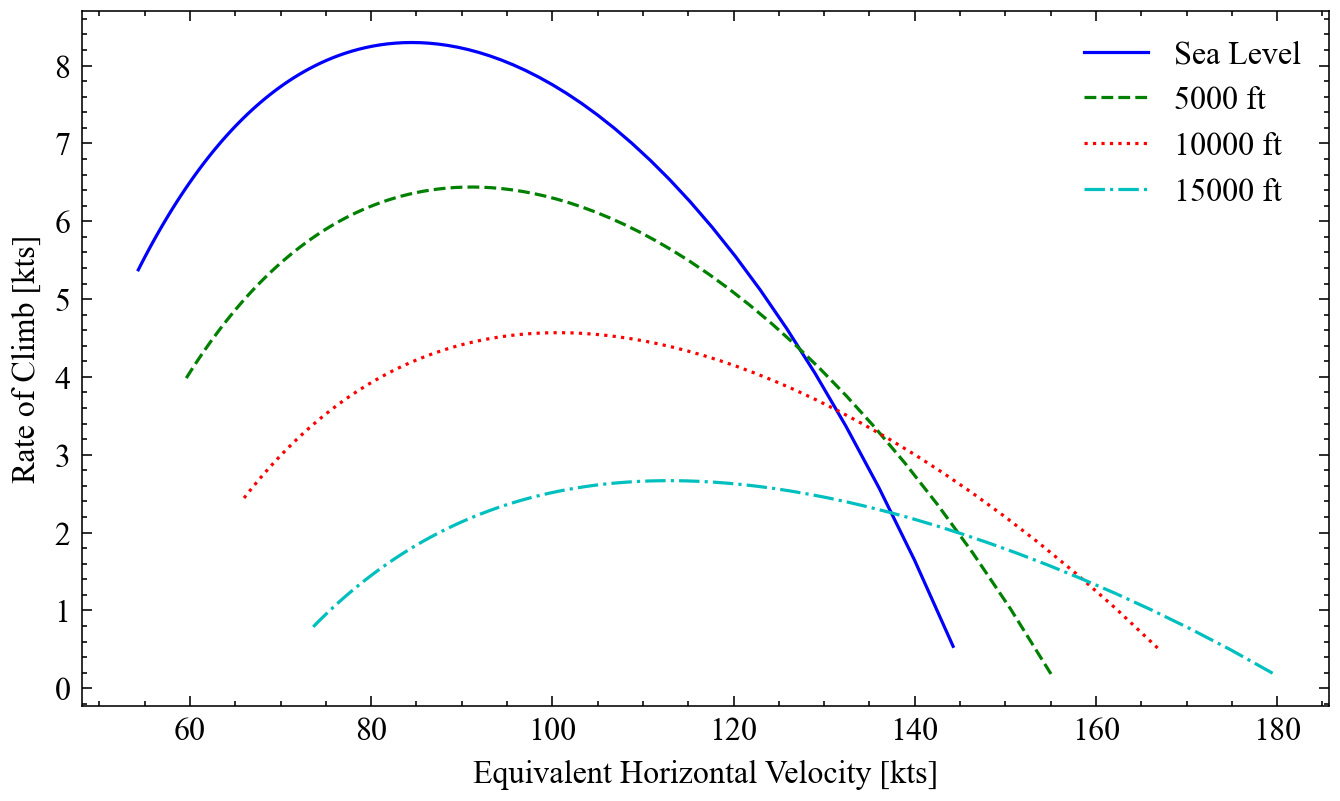

In [9]:
ca.hodograph(metric=False, mode='plot')

In [10]:
hodo_imperial = ca.hodograph(metric=False, mode='data')
hodo_imperial.head()

,True Velocity [kts],0 [ft],5000 [ft],10000 [ft],15000 [ft]
0,53.626924,5.376201,3.959357,2.429977,0.789324
1,53.861945,5.431937,4.010719,2.477796,0.834512
2,54.100084,5.487705,4.062064,2.525557,0.879610
3,54.341410,5.543500,4.113385,2.573253,0.924611
4,54.585994,5.599316,4.164675,2.620877,0.969507


## Part 3 - Plotting Maximum Rate of Climb vs. Altitude

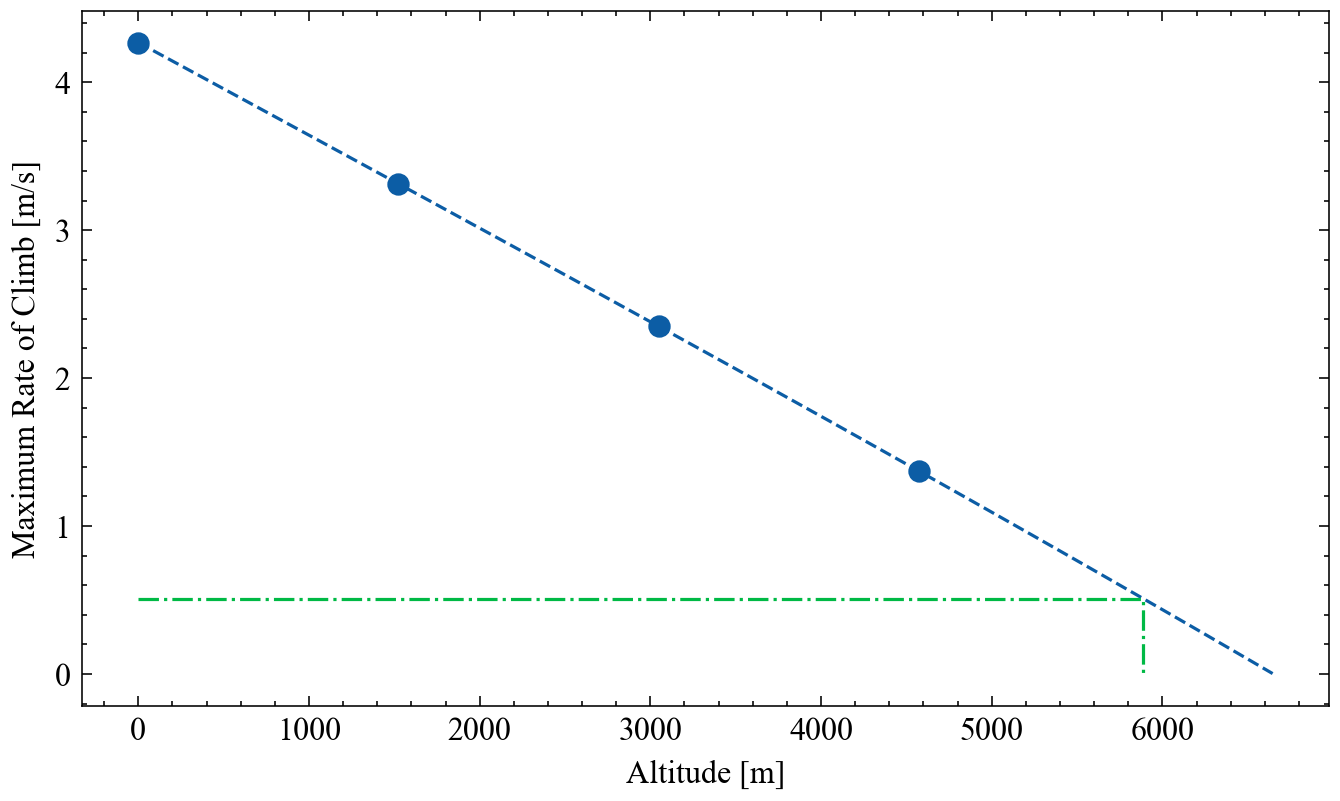

Spline coefficients:  [4.26782383 3.3139551  2.36029124 1.37206328]


In [11]:
ca.ceilings(metric=True, mode='plot')

In [12]:
ceilings_metric = ca.ceilings(metric=True, mode='data')
ceilings_metric

,0
Service Ceiling [m],5888.547459
Absolute Ceiling [m],6645.954711


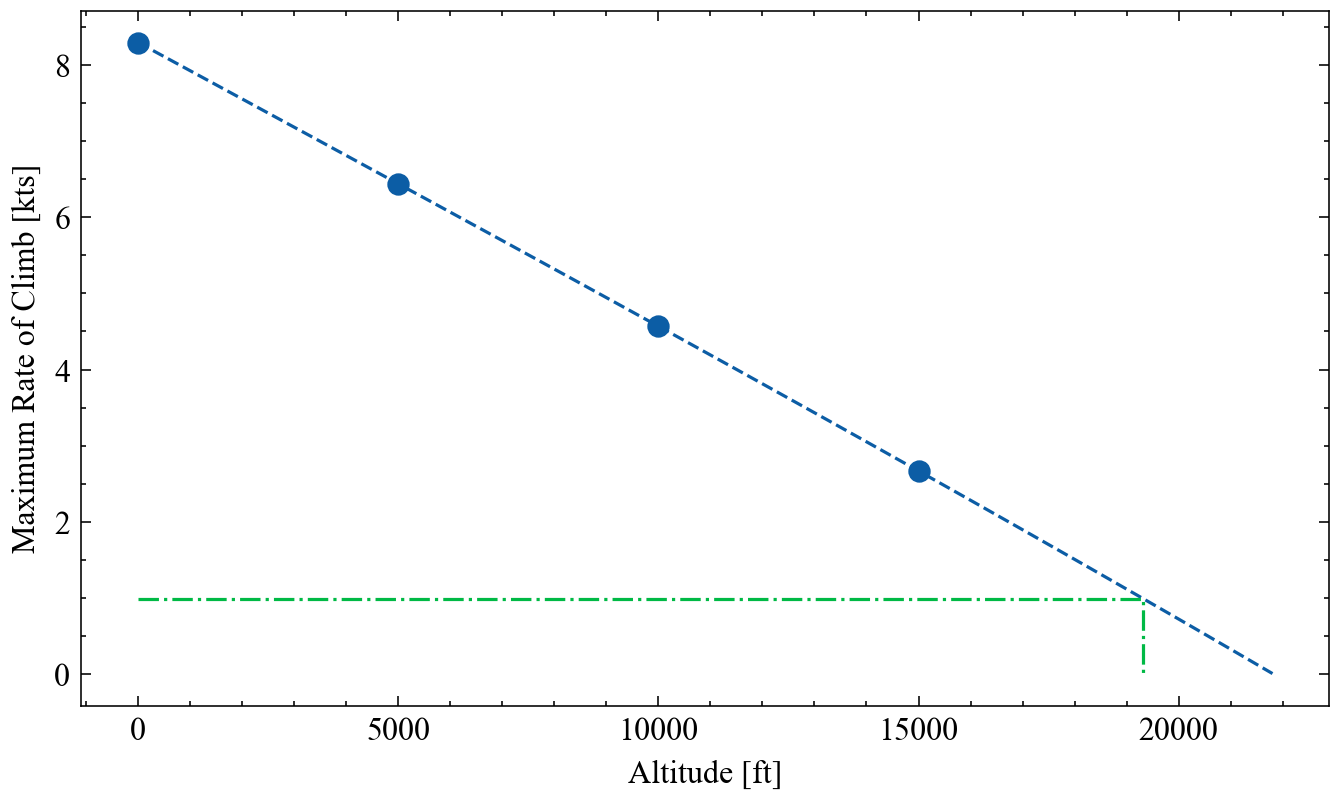

Spline coefficients:  [8.29596668 6.44179848 4.58802853 2.66707149]


In [13]:
ca.ceilings(metric=False, mode='plot')

In [14]:
ceilings_imperial = ca.ceilings(metric=False, mode='data')
ceilings_imperial

,0
Service Ceiling [ft],19319.373469
Absolute Ceiling [ft],21804.313357


## Part 4 - Plotting Time to Climb to Altitude

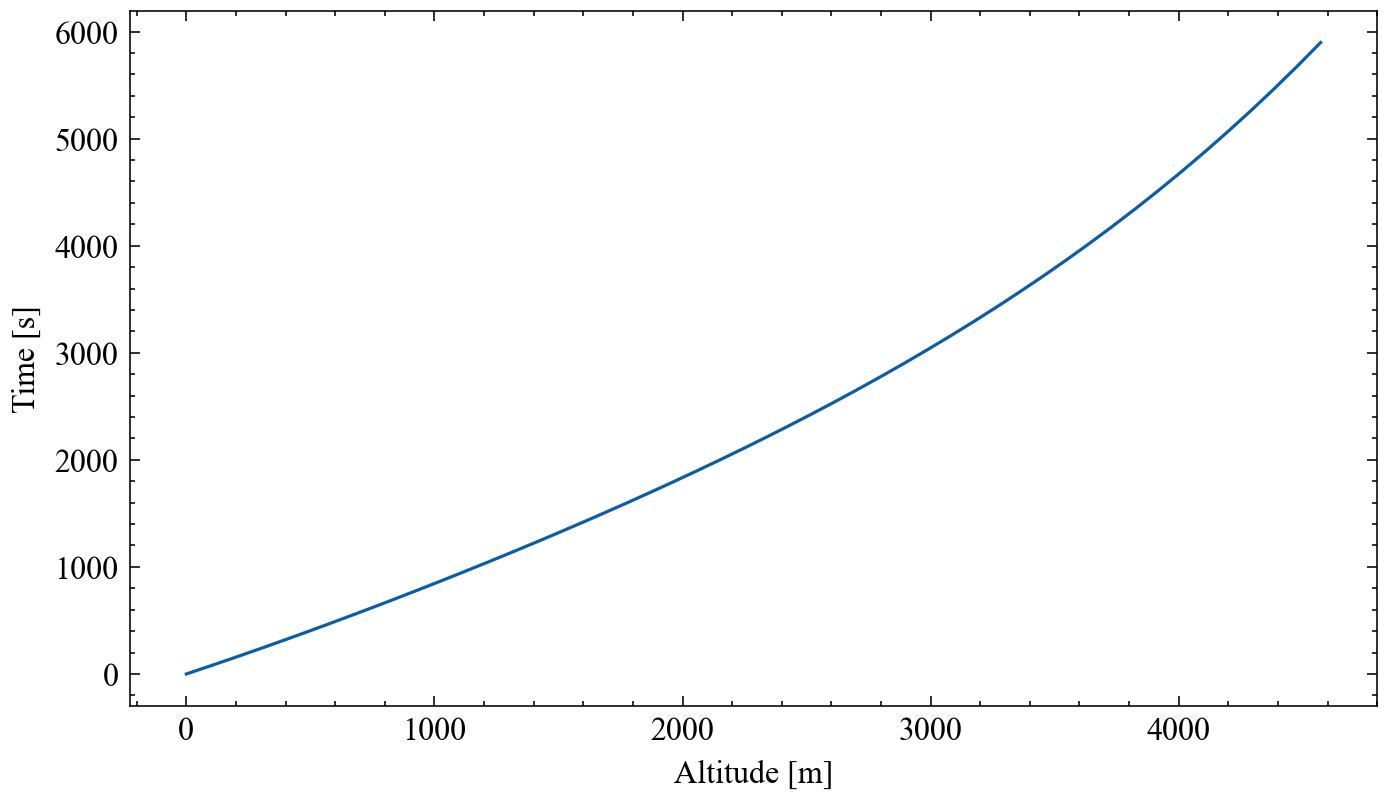

In [15]:
ca.time_to_altitude(metric=True, mode='plot')

In [16]:
time_to_alt_metric = ca.time_to_altitude(metric=True, mode='data')
time_to_alt_metric.head()

,Altitude [m],Time [s]
0,0.000000,0.000000
1,93.306122,72.471573
2,186.612245,146.383045
3,279.918367,221.670040
4,373.224490,298.276865


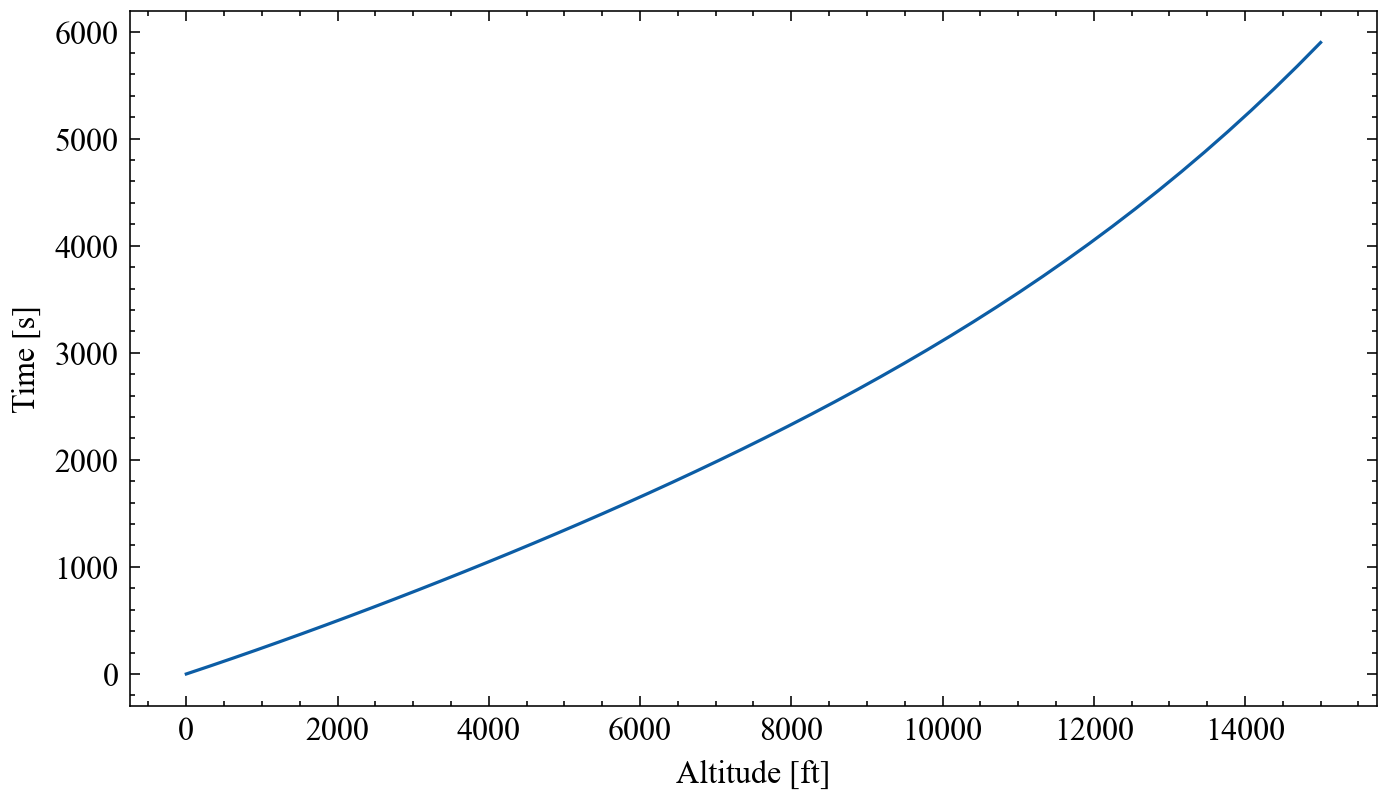

In [17]:
ca.time_to_altitude(metric=False, mode='plot')

In [18]:
time_to_alt_metric = ca.time_to_altitude(metric=False, mode='data')
time_to_alt_metric.head()

,Altitude [ft],Time [s]
0,0.000000,0.000000
1,306.122449,72.471573
2,612.244898,146.383045
3,918.367347,221.670040
4,1224.489796,298.276865


## Part 5 - Plotting Steepest Climb Rate

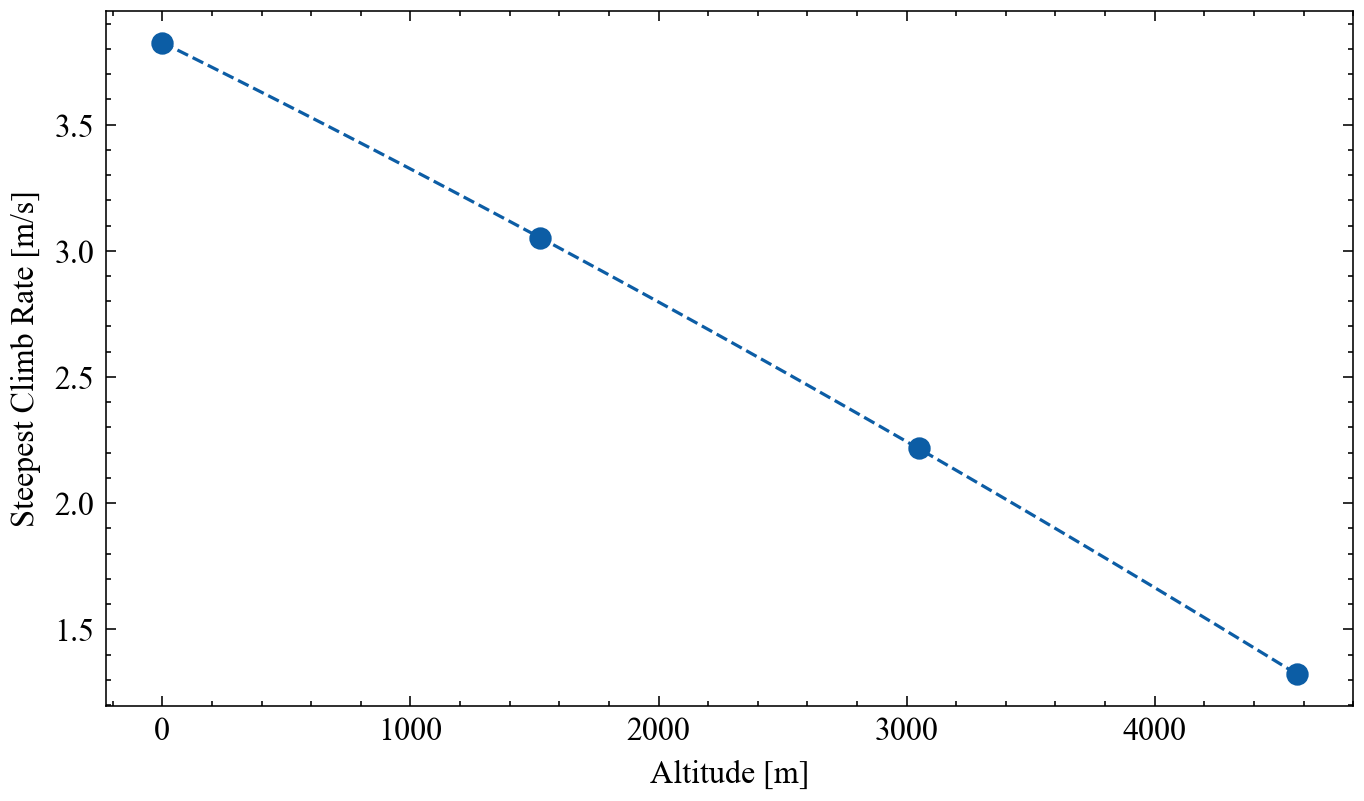

Spline coefficients:  [3.82517351 3.08261434 2.24527646 1.3232299 ]


In [19]:
ca.steepest_climb_rate(metric=True, mode='plot')

In [20]:
steepest_climb_metric = ca.steepest_climb_rate(metric=True, mode='data')
steepest_climb_metric.head()

,Altitude [m],Steepest Climb Rate [m/s]
0,0.0,3.825174
1,1524.0,3.051394
2,3048.0,2.216667
3,4572.0,1.323230


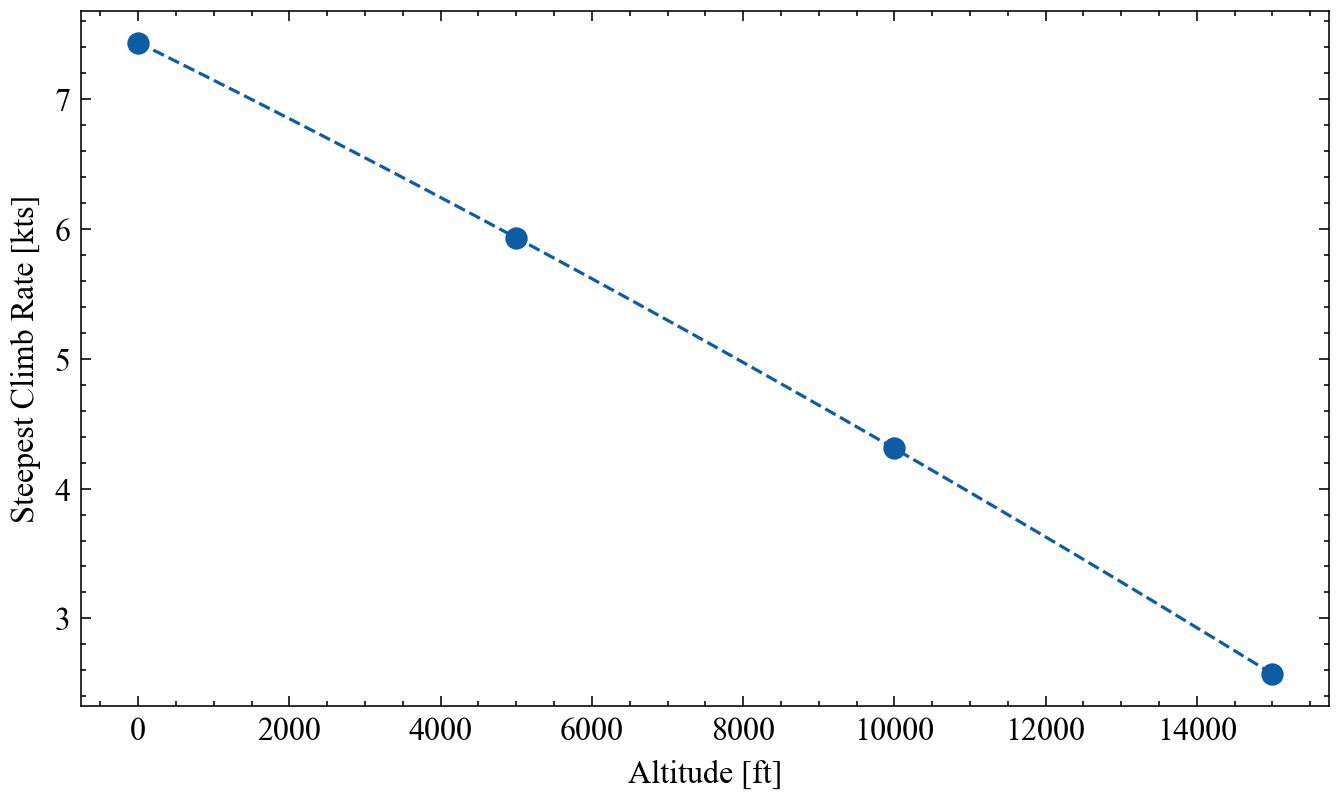

Spline coefficients:  [7.43552527 5.99210905 4.3644582  2.57214722]


In [21]:
ca.steepest_climb_rate(metric=False, mode='plot')

In [22]:
steepest_climb_imperial = ca.steepest_climb_rate(metric=False, mode='data')
steepest_climb_imperial.head()

,Altitude [ft],Steepest Climb Rate [kts]
0,0.0,7.435525
1,5000.0,5.931422
2,10000.0,4.308847
3,15000.0,2.572147


## Miscellaneous Stuff and Testing

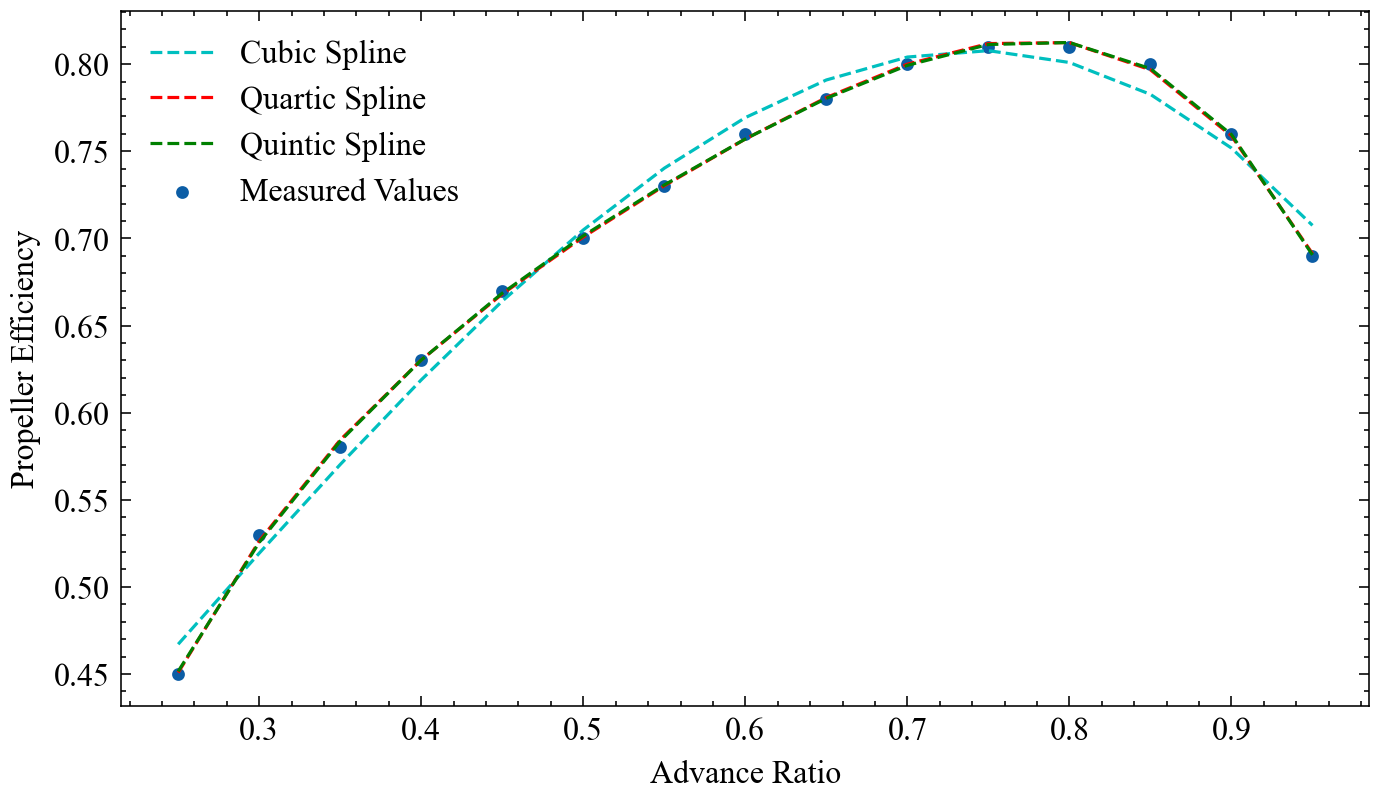

In [23]:
# finding propeller efficiency
adv_ratio = np.linspace(0.25, 0.95, 15)
prop_eff = np.array([0.45, 0.53, 0.58, 0.63, 0.67, 0.70, 0.73, 0.76, 0.78, 0.80, 0.81, 0.81, 0.80, 0.76, 0.69])
prop_eff_interp_3 = interpolate.UnivariateSpline(adv_ratio, prop_eff)
prop_eff_interp_4 = interpolate.UnivariateSpline(adv_ratio, prop_eff, k=4)
prop_eff_interp_5 = interpolate.UnivariateSpline(adv_ratio, prop_eff, k=5)

plt.figure(dpi=230, figsize=(7,4))
plt.style.use(['science', 'no-latex'])

plt.scatter(adv_ratio, prop_eff, marker='.', label='Measured Values')
plt.plot(adv_ratio, prop_eff_interp_3(adv_ratio), color='c', linestyle='--', label='Cubic Spline')
plt.plot(adv_ratio, prop_eff_interp_4(adv_ratio), color='r', linestyle='--', label='Quartic Spline')
plt.plot(adv_ratio, prop_eff_interp_5(adv_ratio), color='g', linestyle='--', label='Quintic Spline')

plt.xlabel('Advance Ratio')
plt.ylabel('Propeller Efficiency')
plt.legend()

plt.show()